# Bach Chorale Generator

For this project, my goal was to create a random chorale generator, based in the style of Johann Sebastian Bach, considered by many to be the greatest composer of the Baroque era (1685-1750). In summary, I perform an analysis on 229 bach chorales, and then use the results of that analysis to generate random chorales based on random weighted choice of chords.

The analysis question: **Can I create a chorale generator using the tools I've learned, and what will that look like?**

A link to the dataset can be found __[here](https://www.kaggle.com/datasets/pranjalsriv/bach-chorales-2)__, with more information on how the data is organized and represented. The most important thing to point out is how the notes are represented. They are represented as *piano key numbers* between the values of 0 - 88 (0 means that no note is played). In this analysis, I use the training set.

The last cell of this project visualizes the top 10 most common chords used in 10 randomly generated chorales in the style of Bach.

In [1]:
# Import modules
from collections import defaultdict
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

In [2]:
# import each bach chorale into a list of pandas dataframes
chorale_lst = []
for i in range(229):
    if len(str(i)) < 2:
        cho = 'chorale_' + '00' + str(i) + '.csv'
        df = pd.read_csv(cho)
        df['chorale_no'] = i
        chorale_lst.append(df)
    elif len(str(i)) < 3:
        cho = 'chorale_' + '0' + str(i) + '.csv'
        df = pd.read_csv(cho)
        df['chorale_no'] = i
        chorale_lst.append(df)
    else:
        cho = 'chorale_' + str(i) + '.csv'
        df = pd.read_csv(cho)
        df['chorale_no'] = i
        chorale_lst.append(df)

# ensure data is cleaned and ready for analysis by ensuring all notes are the same data type (int), as well as between 0 and 88.
# Note that I am checking each note to be between 0 and 88, NOT chorale_no
for ind, c in enumerate(chorale_lst):
    cn, n0, n1, n2, n3 = str(c['chorale_no'].dtypes), str(c['note0'].dtypes), str(c['note1'].dtypes), str(c['note2'].dtypes), str(c['note3'].dtypes)
    assert cn == 'int64', 'chorale_no contains a non_integer datatype'
    assert n0 == 'int64', 'note0 contains a non_integer datatype'    
    assert n1 == 'int64', 'note1 contains a non_integer datatype'
    assert n2 == 'int64', 'note2 contains a non_integer datatype'
    assert n3 == 'int64', 'note3 contains a non_integer datatype'
    
    # ensure all note values are between 0 - 88
    vals = c[['note0','note1','note2','note3']].values
    assert np.any((vals <= 88) & (vals >= 0)), 'there is a note value less then 0 or greater than 88 in the dataframe'
    
display(pd.concat(chorale_lst)) # display all combined dataframes 

,note0,note1,note2,note3,chorale_no
0,74,70,65,58,0
1,74,70,65,58,0
2,74,70,65,58,0
3,74,70,65,58,0
4,75,70,58,55,0
...,...,...,...,...,...
159,69,64,61,45,228
160,69,64,61,45,228
161,69,64,61,45,228
162,69,64,61,45,228


Let's re-organize the dataframe a bit to make more musical sense. Chorale sections are typically seperated by bass, tenor, alto, and soprano (bass being the lower-pitched notes, and soprano being the higher-pitched notes). Occasionally the sections can overlap, but this is rare. I will rename the columns to reflect this, as well as reorganize the columns accordingly.

In [3]:
chorales = pd.concat(chorale_lst)[['chorale_no','note3','note2','note1','note0']].rename(columns={'note3':'bass','note2':'tenor','note1':'alto','note0':'soprano'}).reset_index(drop=True)
display(chorales)

,chorale_no,bass,tenor,alto,soprano
0,0,58,65,70,74
1,0,58,65,70,74
2,0,58,65,70,74
3,0,58,65,70,74
4,0,55,58,70,75
...,...,...,...,...,...
55223,228,45,61,64,69
55224,228,45,61,64,69
55225,228,45,61,64,69
55226,228,45,61,64,69


Now we'll count the frequency of each *chord* in the chorale dataframe, as well as the frequency of *chord pairs*. We'll store these results in two dictionaries respectively. We will inspect each chorale seperately to ensure we are only aggregating chord pairs that are a part of the same chorale (We don't want to count the last chord of a chorale, and the first chord of another chorale, as a chord pair).

In [4]:
chord_pairs = defaultdict(int)
chord_freq = defaultdict(int)

for c in chorales['chorale_no'].unique():
    df = chorales[chorales['chorale_no'] == c]
    for i in range(len(df)):
        b = int(df.iloc[i]['bass'])
        t = int(df.iloc[i]['tenor'])
        a = int(df.iloc[i]['alto'])
        s = int(df.iloc[i]['soprano'])
        try:
            b1 = int(df.iloc[i+1]['bass'])
            t1 = int(df.iloc[i+1]['tenor'])
            a1 = int(df.iloc[i+1]['alto'])
            s1 = int(df.iloc[i+1]['soprano'])
            chord_pairs[(b, t, a, s),(b1, t1, a1, s1)] += 1
            chord_freq[b, t, a, s] += 1
        except: pass

# this for loop I created because the algorithm tends to favor repeating chords, so this essentially reduces the probability
# of a chord repeating. this makes the generator's final result more interesting to listen to. Feel free to comment out this 
# loop if you're interested in what my initial results displayed.
for c in chord_pairs:
    if c[0] == c[1]:
        tot = chord_pairs[c]
        chord_pairs[c] = round(tot/8)
        diff = tot - round(tot/8)
        chord_freq[c[0]] = chord_freq[c[0]] - diff


Next, we'll create our *chords* dataframe. *chord0* will be the initial chord, and *chord1* will be a chord that occurs after chord0. The chords will be stored as tuples, in the following format *(bass, tenor, alto, soprano)*. Then we'lI calculate the conditional probability of which chord Bach is most likely to choose next, given the previous chord. We'll label this new column "weight".

In [5]:
# create two dataframes from the dictionaries we created.
cf_chords = list(chord_freq.keys())
cf_cnts = list(chord_freq.values())

cp_pairs0 = [tup[0] for tup in chord_pairs.keys()]
cp_pairs1 = [tup[1] for tup in chord_pairs.keys()]
cp_cnts = list(chord_pairs.values())

cf_df = pd.DataFrame({'chord0':cf_chords, 'chord0_freq':cf_cnts})
cp_df = pd.DataFrame({'chord0':cp_pairs0,'chord1':cp_pairs1, 'pair_freq':cp_cnts})

# merge into one dataframe assigned to variable 'chords'
chords = cp_df.merge(cf_df, on='chord0')[['chord0','chord1','chord0_freq','pair_freq']]

# create a column called 'weight' which computes the conditional probabilities of the chord pairs
chords['weight'] = chords['pair_freq'] / chords['chord0_freq']

display(chords)

,chord0,chord1,chord0_freq,pair_freq,weight
0,"(58, 65, 70, 74)","(58, 65, 70, 74)",38,7,0.184211
1,"(58, 65, 70, 74)","(55, 58, 70, 75)",38,1,0.026316
2,"(58, 65, 70, 74)","(57, 65, 70, 74)",38,6,0.157895
3,"(58, 65, 70, 74)","(58, 64, 70, 74)",38,1,0.026316
4,"(58, 65, 70, 74)","(60, 63, 67, 72)",38,2,0.052632
...,...,...,...,...,...
16432,"(54, 56, 64, 71)","(54, 56, 64, 71)",2,0,0.000000
16433,"(54, 56, 64, 71)","(52, 57, 66, 71)",2,1,0.500000
16434,"(54, 56, 64, 71)","(56, 57, 64, 73)",2,1,0.500000
16435,"(56, 56, 64, 73)","(56, 56, 64, 73)",1,0,0.000000


Now we're ready to create our function that generates a random chorale of random length, based on Bach's composing tendencies. we will do this by:
1. choosing a random a random chord0 to start with from our chords dataframe. 
2. generate a list of numbers that represent possible lengths for our chorale, then choose one of these numbers randomly as our length.
3. choose the next chord randomly, based on weight of the probabilities calculated above, from a list of possible chord choices that occur *after* chord0 (taken from the chord1 column). I compute the next chord using __[this](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)__ Numpy function.
4. repeat the process until we reach our desired length.



In [6]:
def create_chorale():
    # choose a random chord from chords dataframe 
    ini_chord = np.random.choice(chords['chord0'].unique())

    # generate length list (list of integers where the minimum chorale length is the shortest possible selection,
    # and the maximum chorale length is the longest possible selection). We generate this from the chorales dataframe
    len_lst = []
    for c in chorales['chorale_no'].unique():
        df = chorales[chorales['chorale_no'] == c]
        len_lst.append(len(df))
    len_lst = [i for i in range(min(len_lst), max(len_lst))]
    rand_len = random.choice(len_lst)

    # create a random chorale based on weighted random choice for each chord, 
    # whose length is the random length we just generated.
    probability_chorale = defaultdict(list)
    probability_chorale['chord_progression'].append(ini_chord)
    
    # chord generator
    for i in range(rand_len):
        df = chords[chords['chord0'] == ini_chord].reset_index(drop=True)
        chord1_vals = df['chord1'].values
        chord1_ind = df['chord1'].index.values
        weight_lst = df['weight'].values
        
        # here is where we use the numpy function described above to choose the next chord based on weighted random choice
        next_chord = chord1_vals[int(np.random.choice(chord1_ind, 1, p=weight_lst))]
        probability_chorale['chord_progression'].append(next_chord)
        ini_chord = next_chord
    
    # return the results in a pandas dataframe. we'll seperate the resulting chord voices back into their respective columns,
    # which are bass, tenor, alto, and soprano
    b = [i[0] for i in probability_chorale['chord_progression']]
    t = [i[1] for i in probability_chorale['chord_progression']]
    a = [i[2] for i in probability_chorale['chord_progression']]
    s = [i[3] for i in probability_chorale['chord_progression']]
    return pd.DataFrame({'bass':b,'tenor':t,'alto':a,'soprano':s})

Feel free to run the cell below multiple times to generate your own unique chorales!

In [22]:
prob_chorale = create_chorale()

b = prob_chorale['bass'].values
t = prob_chorale['tenor'].values
a = prob_chorale['alto'].values
s = prob_chorale['soprano'].values
chord_set = set(zip(b, t, a, s))

print('this chorale contains ' + str(len(prob_chorale)) + ' time steps, and has ' + str(len(chord_set)) + ' unique chords!')
display(prob_chorale)

this chorale contains 265 time steps, and has 71 unique chords!


,bass,tenor,alto,soprano
0,57,65,69,72
1,57,65,69,72
2,53,65,69,72
3,53,65,69,72
4,53,65,69,72
...,...,...,...,...
260,55,61,64,69
261,55,61,64,69
262,55,61,64,69
263,55,61,64,69


Just for fun, let's create a visualization that displays the top 10 most commonly used chord in 10 randomly generated chorales. You can also run the code cell below multiple times to display different results, as we are generation new chorales for each visualization we create. It's interesting to see the diversity!

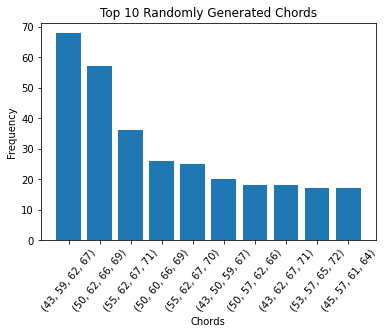

In [8]:
cdic = defaultdict(int)

for _ in range(10):
    prob_chorale = create_chorale()
    
    b = prob_chorale['bass'].values
    t = prob_chorale['tenor'].values
    a = prob_chorale['alto'].values
    s = prob_chorale['soprano'].values
    chord_set = list(zip(b, t, a, s))
    
    for c in chord_set:
        cdic[c] += 1

dic = dict(sorted(cdic.items(), key=lambda i: i[1], reverse=True))
k = list(dic.keys())[:10]
k = [str(i) for i in k]
v = list(dic.values())[:10]

plt.bar(range(len(v)), v, align='center')
plt.xticks(range(len(k)), k, rotation = 50)
plt.title('Top 10 Randomly Generated Chords')
plt.xlabel('Chords')
plt.ylabel('Frequency')

plt.show()

I created a short mp3 file consisting of the first 16 chords from one of the random chorales I generated if you'd like to hear what it sounds like. the file can be found __[here](https://voca.ro/13G1ZmfkgFiB)__

The code cell below contains the module, and code, used to export the midi files for each section. It's a fairly obscure module, so chances are you'd need to install it before using it, which is why I commented out the code cell. Feel free to uncomment it and give it a shot if you are interested.

In [9]:
# from midiutil.MidiFile import MIDIFile

# prob_chorale = create_chorale()

# b = prob_chorale['bass'].values
# t = prob_chorale['tenor'].values 
# a = prob_chorale['alto'].values
# s = prob_chorale['soprano'].values


# degrees  = b 
# track    = 0
# channel  = 0
# time     = 0   # In beats
# duration = 1   # In beats
# tempo    = 60  # In BPM
# volume   = 100 # 0-127, as per the MIDI standard

# MyMIDI = MIDIFile(1) # One track, defaults to format 1 (tempo track
#                      # automatically created)
# MyMIDI.addTempo(track,time, tempo)

# for pitch in degrees:
#     MyMIDI.addNote(track, channel, pitch, time, duration, volume)
#     time = time + 1

# with open("bass.mid", "wb") as output_file:
#     MyMIDI.writeFile(output_file)
    
# degrees  = t
# track    = 0
# channel  = 0
# time     = 0   # In beats
# duration = 1   # In beats
# tempo    = 60  # In BPM
# volume   = 100 # 0-127, as per the MIDI standard

# MyMIDI = MIDIFile(1) # One track, defaults to format 1 (tempo track
#                      # automatically created)
# MyMIDI.addTempo(track,time, tempo)

# for pitch in degrees:
#     MyMIDI.addNote(track, channel, pitch, time, duration, volume)
#     time = time + 1

# with open("tenor.mid", "wb") as output_file:
#     MyMIDI.writeFile(output_file)

# degrees  = a
# track    = 0
# channel  = 0
# time     = 0   # In beats
# duration = 1   # In beats
# tempo    = 60  # In BPM
# volume   = 100 # 0-127, as per the MIDI standard

# MyMIDI = MIDIFile(1) # One track, defaults to format 1 (tempo track
#                      # automatically created)
# MyMIDI.addTempo(track,time, tempo)

# for pitch in degrees:
#     MyMIDI.addNote(track, channel, pitch, time, duration, volume)
#     time = time + 1

# with open("alto.mid", "wb") as output_file:
#     MyMIDI.writeFile(output_file)

# degrees  = s
# track    = 0
# channel  = 0
# time     = 0   # In beats
# duration = 1   # In beats
# tempo    = 60  # In BPM
# volume   = 100 # 0-127, as per the MIDI standard

# MyMIDI = MIDIFile(1) # One track, defaults to format 1 (tempo track
#                      # automatically created)
# MyMIDI.addTempo(track,time, tempo)

# for pitch in degrees:
#     MyMIDI.addNote(track, channel, pitch, time, duration, volume)
#     time = time + 1

# with open("soprano.mid", "wb") as output_file:
#     MyMIDI.writeFile(output_file)

# Chord Rankings

I think another interesting experiment would be to perform a __[markov chain](https://en.wikipedia.org/wiki/Markov_chain)__ analysis on the chords in this dataset (we've performed some of the work needed to do this already). This will tell us which chord we are most likely to end up on after a certain amount of chord changes, after randomly choosing a starting chord (chord0). We already have the code needed to build a *chords* dataframe. Let's rebuild the dataframe **without** reducing the probability of repeating chords, in order to get an accurate chord ranking

In [10]:
chord_pairs = defaultdict(int)
chord_freq = defaultdict(int)

for c in chorales['chorale_no'].unique():
    df = chorales[chorales['chorale_no'] == c]
    for i in range(len(df)):
        b = int(df.iloc[i]['bass'])
        t = int(df.iloc[i]['tenor'])
        a = int(df.iloc[i]['alto'])
        s = int(df.iloc[i]['soprano'])
        try:
            b1 = int(df.iloc[i+1]['bass'])
            t1 = int(df.iloc[i+1]['tenor'])
            a1 = int(df.iloc[i+1]['alto'])
            s1 = int(df.iloc[i+1]['soprano'])
            chord_pairs[(b, t, a, s),(b1, t1, a1, s1)] += 1
            chord_freq[b, t, a, s] += 1
        except: pass

# create two dataframes from the dictionaries we created.
cf_chords = list(chord_freq.keys())
cf_cnts = list(chord_freq.values())

cp_pairs0 = [tup[0] for tup in chord_pairs.keys()]
cp_pairs1 = [tup[1] for tup in chord_pairs.keys()]
cp_cnts = list(chord_pairs.values())

cf_df = pd.DataFrame({'chord0':cf_chords, 'chord0_freq':cf_cnts})
cp_df = pd.DataFrame({'chord0':cp_pairs0,'chord1':cp_pairs1, 'pair_freq':cp_cnts})

# merge into one dataframe assigned to variable 'chords'
chords = cp_df.merge(cf_df, on='chord0')[['chord0','chord1','chord0_freq','pair_freq']]

# create a column called 'weight' which computes the conditional probabilities of the chord pairs
chords['weight'] = chords['pair_freq'] / chords['chord0_freq']

display(chords)

,chord0,chord1,chord0_freq,pair_freq,weight
0,"(58, 65, 70, 74)","(58, 65, 70, 74)",90,59,0.655556
1,"(58, 65, 70, 74)","(55, 58, 70, 75)",90,1,0.011111
2,"(58, 65, 70, 74)","(57, 65, 70, 74)",90,6,0.066667
3,"(58, 65, 70, 74)","(58, 64, 70, 74)",90,1,0.011111
4,"(58, 65, 70, 74)","(60, 63, 67, 72)",90,2,0.022222
...,...,...,...,...,...
16432,"(54, 56, 64, 71)","(54, 56, 64, 71)",4,2,0.500000
16433,"(54, 56, 64, 71)","(52, 57, 66, 71)",4,1,0.250000
16434,"(54, 56, 64, 71)","(56, 57, 64, 73)",4,1,0.250000
16435,"(56, 56, 64, 73)","(56, 56, 64, 73)",2,1,0.500000


Next we'll create a dataframe called *unique_chords* that associates each unique chord with an index number, merge that dataframe with the *chords* dataframe, and use those index values and weight to construct our sparse matrix.

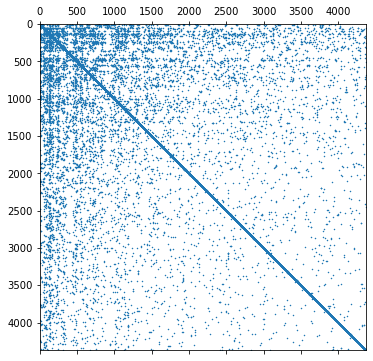

In [11]:
# create dictionary with 'chords' as keys, and unique index numbers as values
chord_to_i = {}
ind = 0
for i in range(len(chords)):
    chord0 = chords.iloc[i]['chord0']
    if chord0 in chord_to_i:
        continue
    else:
        chord_to_i[chord0] = ind
        ind += 1

# create 'unique_chords' dataframe from 'chord_to_i' dictionary
unique_chords = pd.DataFrame({'chord0':list(chord_to_i.keys()), 'i':list(chord_to_i.values())})

# ensure there are no duplicate chords in the dataframe
assert len(unique_chords) == len(unique_chords['chord0'].drop_duplicates())

# create our initial vector of starting probabilities (each chord has an equal chance of being picked as the first chord)
unique_chords['x0[i]'] = 1 / len(unique_chords)

# merge dataframes
chords = unique_chords.merge(chords, on='chord0').rename(columns={'i':'chord0_index'})
del chords['x0[i]']
unique_chords = unique_chords.rename(columns={'chord0':'chord1'})
chords = unique_chords.merge(chords, on='chord1').rename(columns={'i':'chord1_index'})
chords = chords[['chord0','chord0_index','chord1','chord1_index','weight']]

# construct our sparse matrix
n = len(unique_chords)
P = coo_matrix((chords['weight'],
               (chords['chord0_index'], chords['chord1_index'])),
                shape=(n, n))

# function for visualizing a sparse matrix
def spy(A, figsize=(6, 6), markersize=0.5):
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()

spy(P)

Now create our chord rank function to discover which chord we are most likely to end up on after *t* time steps. The time steps are calculated randomly based on a list of integers ranged from the smallest chorale length to the largest chorale length. Although the end results are usually very similar, there are occasionally variations around ranks 5-10.

In [12]:
# choose random time step
len_lst = [len(chorales[chorales['chorale_no'] == c]) for c in chorales['chorale_no'].unique()]
len_lst = [i for i in range(min(len_lst), max(len_lst))]
rand_len = random.choice(len_lst)

# function for calculating chord rankings. 'P' is our sparse matrix of probabilities, 'x0' is our initial probability vector,
# and 't' is our random time step length calculated above
def chord_rank(P, x0, t):
    x = x0
    for t in range(t):
        x = P.T.dot(x)
    return x

# create a dataframe of the top 10 chords Bach is most likely to end up on, after choosing a random starting chord.
x = chord_rank(P, unique_chords['x0[i]'], rand_len)
print("\n=== Top 10 Chords for a chorale that is", str(rand_len), "time steps  ===\n")
ranks = np.argsort(-x)
top10 = pd.DataFrame({'Rank': np.arange(1, 11),
                      'Chord': chords.iloc[ranks[:10]]['chord0'],
                      'x(t)': x[ranks[:10]]})
top10[['x(t)', 'Rank', 'Chord']]
display(top10)


=== Top 10 Chords for a chorale that is 391 time steps  ===



,Rank,Chord,x(t)
143,1,"(55, 58, 67, 74)",0.026521
97,2,"(57, 60, 67, 72)",0.014984
310,3,"(53, 62, 70, 79)",0.013004
126,4,"(57, 57, 64, 72)",0.010652
114,5,"(50, 62, 65, 77)",0.009449
90,6,"(58, 63, 67, 74)",0.009318
135,7,"(57, 60, 66, 72)",0.008554
242,8,"(55, 58, 67, 75)",0.008491
56,9,"(48, 63, 69, 75)",0.008093
479,10,"(54, 60, 69, 69)",0.007943


**Conclusion**: this was an interesting experiment using probabliity to construct random chorales/ chord progressions in Bach's style. The final product does sound good, but naturally it also sounds a bit robotic, and often lacking direction. But I think this is a good starting point at creating an algorithm generates more *human* sounding chorales in Bach's style.

While the chord ranking algorithm was an interesting exercise, I don't believe there are many strong conclusions you could make based on the results, since the first chord rank is only around 2.6 - 2.7 percent, depending on the amount of time steps.